In [1]:
from CentralStreamingModel.utils.read_probabilities import VD_los
from CentralStreamingModel.skewt import skewt as st
from CentralStreamingModel.skewt import skewt_moments
from scipy.integrate import simps
import numpy as np
import matplotlib.pyplot as plt
from CentralStreamingModel.integral import real2redshift as real2red
import os, glob
import pickle
from scipy.stats import norm
from scipy.optimize import curve_fit
from halotools.mock_observables import tpcf_multipole
import seaborn as sns
from scipy.misc import derivative, factorial2, factorial
from scipy.interpolate import UnivariateSpline

sns.set_context('talk')

In [2]:
import importlib
importlib.reload(st)

<module 'CentralStreamingModel.skewt.skewt' from '/home/c-cuesta/CentralStreamingModel/skewt/skewt.py'>

In [3]:
n_boxes = range(1,14)
boxsize = 2000
snapshot = 11

central_halos = []
for i, box in enumerate(n_boxes):
    central_halos.append(VD_los('halos', box, boxsize, snapshot,extra = 'r2'))

In [4]:
# Get mean los PDF
central_halos_pdf = [halo.jointpdf for halo in central_halos]

mean_los_pdf = np.mean(central_halos_pdf, axis=0)
std_los_pdf = np.std(central_halos_pdf, axis=0)

In [5]:
# Get mean real and redshift TPCF
data_dir = '/raid/c-cuesta/tpcfs/'

# Load real space tpcf
list_dictionaries = []
os.chdir(data_dir + 'real/')
for real_tpcf in glob.glob(f"*_s{snapshot:03d}.pickle"):
    with open(real_tpcf, "rb") as input_file:
        list_dictionaries.append(pickle.load(input_file))
tpcfs = [dictionary['tpcf'] for dictionary in list_dictionaries]
mean_tpcf = np.mean(tpcfs, axis=0)
std_tpcf = np.std(tpcfs, axis=0)

mean_tpcf_dict =  {'r': list_dictionaries[0]['r'], 'tpcf': mean_tpcf}   

In [6]:
# Load reshift space tpcf
list_dictionaries = []
os.chdir(data_dir + 'redshift/')
for real_tpcf in glob.glob(f"box???_s{snapshot:03d}.pickle"):
    with open(real_tpcf, "rb") as input_file:
        list_dictionaries.append(pickle.load(input_file))

In [7]:
monopoles = [dictionary['mono'] for dictionary in list_dictionaries]
mean_mono = np.mean(monopoles, axis=0)
std_mono = np.std(monopoles, axis=0)

quadrupoles = [dictionary['quad'] for dictionary in list_dictionaries]
mean_quad = np.mean(quadrupoles, axis=0)
std_quad = np.std(quadrupoles, axis=0)

hexadecapoles = [dictionary['hexa'] for dictionary in list_dictionaries]
mean_hexa = np.mean(hexadecapoles, axis=0)
std_hexa = np.std(hexadecapoles, axis=0)

In [8]:
s = np.arange(0.,50.,1)
mu = np.linspace(0.,1,60)

In [9]:
measured_pi_sigma = np.mean([dictionary['pi_sigma'] for dictionary in list_dictionaries], axis=0)


## Streaming Model

In [10]:
rparallel, integrand, pdf_con = real2red.compute_integrand_s_mu(s,
                    mu, mean_tpcf_dict, mean_los_pdf,
                   central_halos[0].r.t, central_halos[0].r.r, central_halos[0].v )

## Gaussian/ST Streaming Model

In [11]:
def gaussian(v, mean, std):
    return norm.pdf(v, loc = mean, scale = std)

In [12]:
gaussian_los_pdf = np.zeros_like(mean_los_pdf)
bf_gaussian_los_pdf = np.zeros_like(mean_los_pdf)

st_los_pdf = np.zeros_like(mean_los_pdf)
bf_st_los_pdf = np.zeros_like(mean_los_pdf)

vlos = central_halos[0].v

for i, rperp in enumerate(central_halos[0].r.t):
    for j, rpar in enumerate(central_halos[0].r.r):
        
        # Measure moments
        mean = simps(mean_los_pdf[i,j] * vlos, vlos)
        std = np.sqrt(simps(mean_los_pdf[i,j] * (vlos - mean)**2, vlos))
        gamma1 = simps(mean_los_pdf[i,j] * (vlos - mean)**3, vlos)/std**3
        gamma2 = simps(mean_los_pdf[i,j] * (vlos - mean)**4, vlos)/std**4 - 3.
        
        gaussian_los_pdf[i, j, :] = norm.pdf(vlos, loc = mean, scale = std)
        
        # Moments to ST parameters
        
        v_c, w, alpha, nu = skewt_moments.moments2parameters(mean, std, gamma1, gamma2)
        
        st_los_pdf[i,j,:] = st.skewt_pdf(vlos, w, v_c, alpha, nu)
        
        
        popt, pcov = curve_fit(gaussian, vlos, mean_los_pdf[i,j,:]) 
        
        bf_gaussian_los_pdf[i,j,:] = norm.pdf(vlos, loc = popt[0], scale = popt[1])
        
        popt, pcov = curve_fit(st.skewt_pdf, vlos, 
                                    mean_los_pdf[i,j,:],
                                     p0 = [ 5.,  2.,-0.2, 30.])
        
        bf_st_los_pdf[i,j,:] = st.skewt_pdf(vlos,
                                   *popt)

/home/c-cuesta/.conda/envs/carol/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5204: RuntimeWarning: overflow encountered in power
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)
/home/c-cuesta/.conda/envs/carol/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5204: RuntimeWarning: overflow encountered in multiply
  Px /= np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)


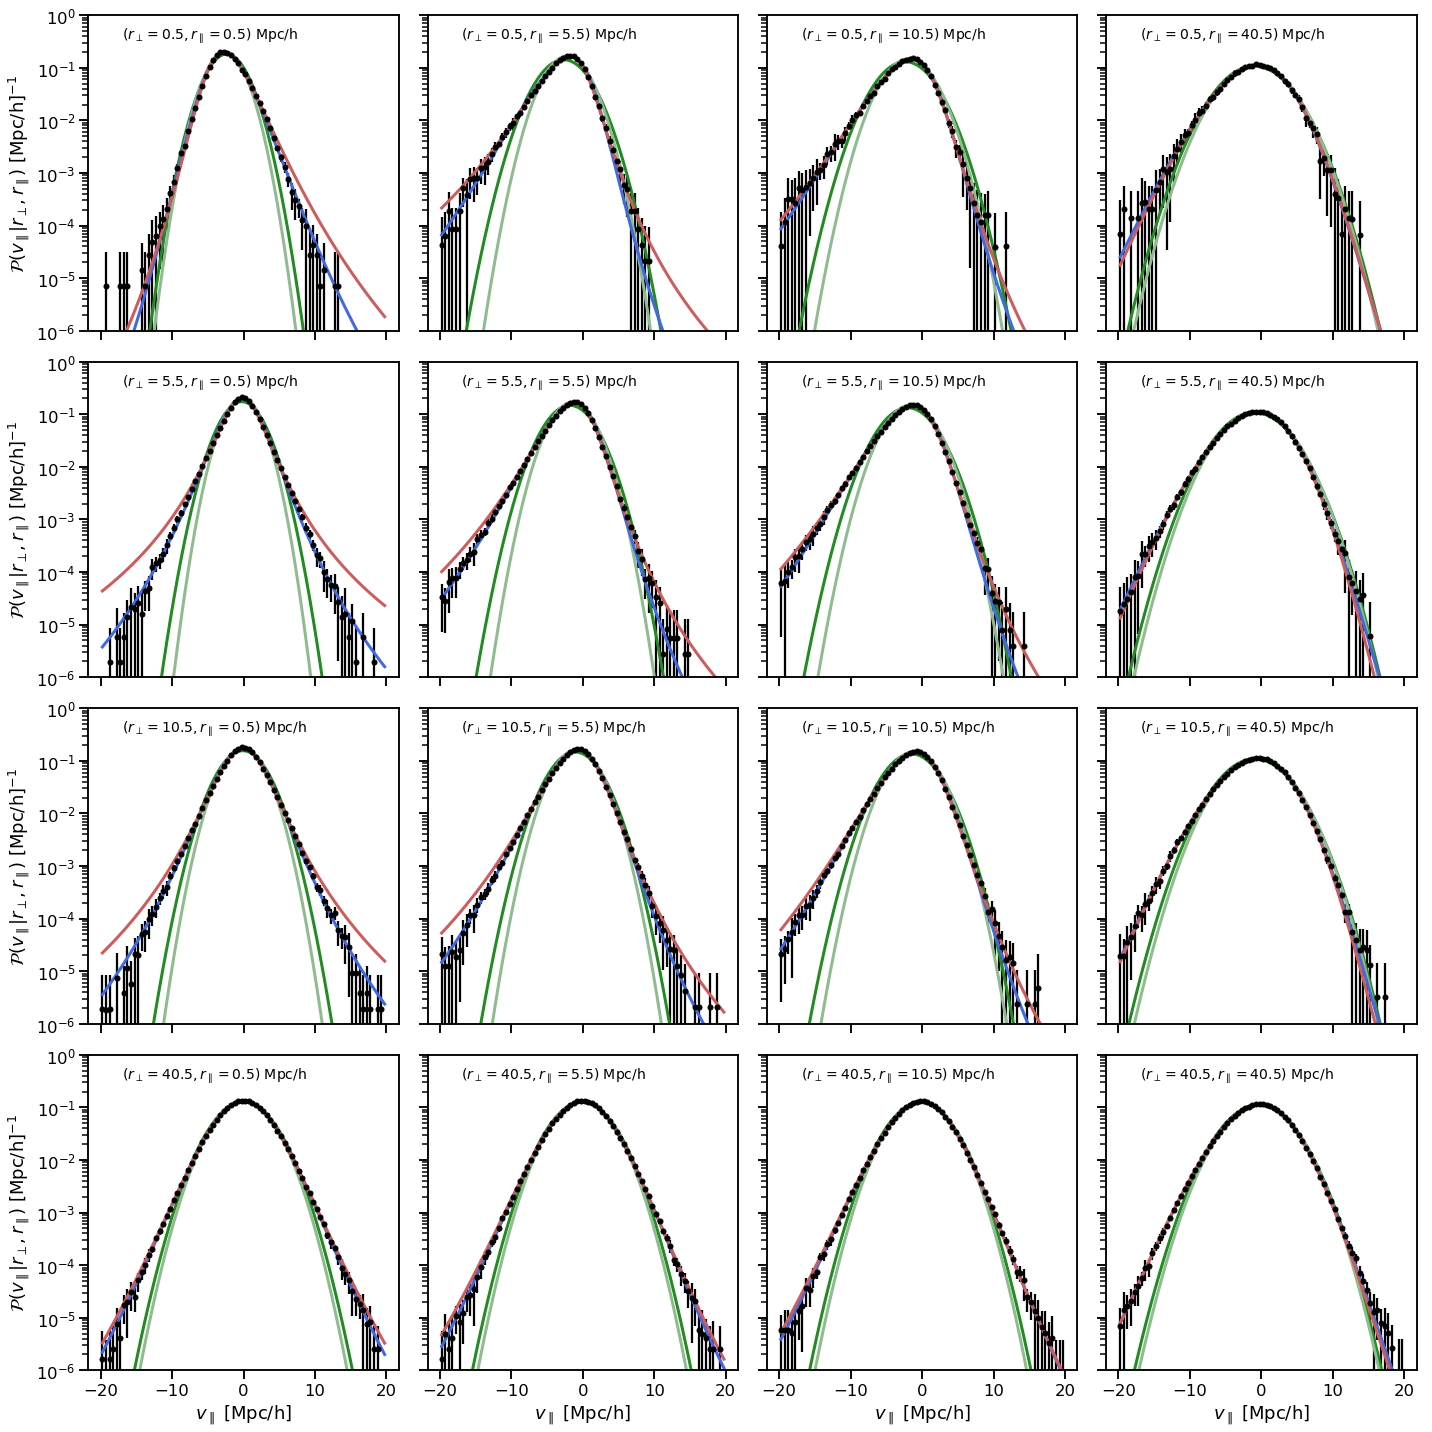

In [13]:
rlist1 = [0,5,10,40]
rlist2 = [0,5,10,40]

fig, axes = plt.subplots(nrows=len(rlist2),
                         ncols=len(rlist1),sharex=True,
                         sharey=True, figsize=(20,20))

for i, rperp in enumerate(rlist2):
    for j, rparal in enumerate(rlist1):
        axes[i,j].text(-17,3.5e-1,r'($ r_\perp = %.1f'
                       ', r_\parallel = %.1f)$ Mpc/h'%(central_halos[0].r.t[rperp],
                                                       central_halos[0].r.t[rparal]),fontsize=14)
        axes[i,j].errorbar(central_halos[0].v, mean_los_pdf[rperp,rparal], 
                yerr = std_los_pdf[rperp,rparal],
                linestyle='', marker='o',
                markersize = 5, color='k', label='Measured')
        
        axes[i,j].plot(central_halos[0].v, gaussian_los_pdf[rperp,rparal], 
                linestyle='-',color='forestgreen', label='Gaussian', linewidth=3)
        
        axes[i,j].plot(central_halos[0].v, bf_gaussian_los_pdf[rperp,rparal], 
                linestyle='-',color='darkseagreen', label='Gaussian - BF', linewidth=3)
        
        axes[i,j].plot(central_halos[0].v, st_los_pdf[rperp,rparal], 
                linestyle='-',  color='royalblue', label='ST', linewidth=3)
        
        axes[i,j].plot(central_halos[0].v, bf_st_los_pdf[rperp,rparal], 
                linestyle='-',  color='indianred', label='ST - BF', linewidth=3)

        axes[i,j].set_yscale("log", nonposy='clip')

        axes[i,j].set_ylim(1e-6,0.99)
        if j == 0:
            axes[i,j].set_ylabel(r'$\mathcal{P}(v_\parallel | r_\perp, r_\parallel)$ [Mpc/h]$^{-1}$')
            labels = list(axes[i,j].get_yticklabels())
            labels[-1] = ''
            axes[i,j].set_yticklabels(labels)
            
        if i == len(rlist2)-1:
            axes[i,j].set_xlabel(r'$v_\parallel$ [Mpc/h]')
            
        #if i==len(rlist2)-1 and j==0:
        #    axes[i,j].legend()
            
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
#plt.savefig(plots_dir + 'los.pdf', dpi=240)

## ST Streaming Model

In [14]:
rparallel, gaussian_integrand, pdf_con = real2red.compute_integrand_s_mu(s,
                    mu, mean_tpcf_dict, gaussian_los_pdf,
                   central_halos[0].r.t, central_halos[0].r.r, central_halos[0].v )

In [15]:
rparallel, bf_gaussian_integrand, pdf_con = real2red.compute_integrand_s_mu(s,
                    mu, mean_tpcf_dict, bf_gaussian_los_pdf,
                   central_halos[0].r.t, central_halos[0].r.r, central_halos[0].v )

In [16]:
rparallel, st_integrand, pdf_con = real2red.compute_integrand_s_mu(s,
                    mu, mean_tpcf_dict, st_los_pdf,
                   central_halos[0].r.t, central_halos[0].r.r, central_halos[0].v )

In [17]:
rparallel, bf_st_integrand, pdf_con = real2red.compute_integrand_s_mu(s,
                    mu, mean_tpcf_dict, bf_st_los_pdf,
                   central_halos[0].r.t, central_halos[0].r.r, central_halos[0].v )

In [18]:
from scipy.interpolate import interp1d, interp2d

In [19]:
interp_twopcf = interp1d(mean_tpcf_dict['r'], mean_tpcf_dict['tpcf'], kind = 'cubic',                                             
    fill_value = (-1., mean_tpcf_dict['tpcf'][-1]), bounds_error=False)   

In [20]:
plt.plot(simps(central_halos[i].jointpdf[sperp,:] * vlos, vlos, axis  = -1))

NameError: name 'sperp' is not defined

Text(0, 0.5, '$\\frac{d \\mu}{d s_\\parallel}$')

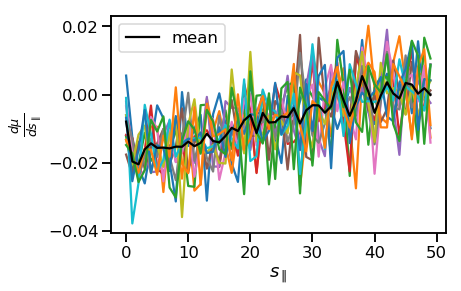

In [21]:
derivative_ind = []
sperp = 48
for i in range(len(central_halos)):
    m1 = simps(central_halos[i].jointpdf[sperp,:] * vlos, vlos, axis  = -1)
    m1_interp = interp1d(central_halos[0].r.r, m1, fill_value = (m1[0], m1[-1]),bounds_error = False)
    #plt.plot(m1_interp(central_halos[0].r.r))
    #plt.plot(m1, linestyle='', marker='o', markersize=2)
    #plt.show()

    plt.plot(derivative(m1_interp, central_halos[0].r.t, order=7))
    derivative_ind.append(derivative(m1_interp, central_halos[0].r.t, order=7))
    
derivative_mean = np.mean(derivative_ind, axis=0)
    
plt.plot(derivative_mean, color='black', label='mean')
plt.legend()
plt.xlabel(r'$s_\parallel$')
plt.ylabel(r'$\frac{d \mu}{d s_\parallel}$')

In [ ]:
approx = np.zeros((len(central_halos[0].r.t), len(central_halos[0].r.t)))
for i, rperp in enumerate(central_halos[0].r.t):
    m1_interp, m2_interp, m2_interp_2 = [], [], []
    for box in range(len(central_halos)):
        m1 = simps(central_halos[box].jointpdf[i,:] * vlos, vlos, axis  = -1)
        
        m1_interp.append(interp1d(central_halos[0].r.r, m1, fill_value = (m1[0], m1[-1]),bounds_error = False))

        m2 = simps(central_halos[box].jointpdf[i,:] * vlos**2, vlos, axis  = -1)
        m2_interp.append(interp1d(central_halos[0].r.r, m2, fill_value = (m2[0], m2[-1]),bounds_error = False))
        m2_interp_2.append(interp1d(central_halos[0].r.r, m2**2, fill_value = (m2[0], m2[-1]),bounds_error = False))


    for j, rpar in enumerate(central_halos[0].r.t):
        #print(rpar)
        dm1_s, ddm2_s, ddddm2_s_2 = [], [], []
        for box in range(len(central_halos)):
            dm1_s.append(derivative(m1_interp[box], rpar, order=5))
        
        
            ddm2_s.append(derivative(m2_interp[box], rpar, n=2, order=5))

            #ddddm2_s_2.append(derivative(m2_interp_2[box], rpar, n=4, order=5))

        r = np.sqrt(rperp ** 2 + rpar**2)
        
        
        approx[i,j] =  interp_twopcf(r) - np.mean(dm1_s,axis=0) + 0.5 * np.mean(ddm2_s, axis = 0)
        #factorial2(3)/factorial(4) * np.mean(ddddm2_s_2, axis = 0)
        

Text(0, 0.5, '$\\frac{d \\mu}{d s_\\parallel}$')

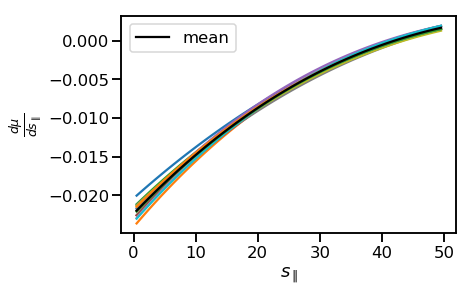

In [290]:
derivative_ind = []
sperp = 48
for i in range(len(central_halos)):
    m1 = simps(central_halos[i].jointpdf[sperp,:] * vlos, vlos, axis  = -1)
    m1_interp = UnivariateSpline(central_halos[0].r.r, 
                m1, s=0.3, k=4)#fill_value = (m1[0], m1[-1]),bounds_error = False)

    #plt.plot(central_halos[0].r.r,m1_interp(central_halos[0].r.r))
    #plt.plot(central_halos[0].r.r, m1, linestyle = '', markersize = 2, marker='o')
    
    #plt.show()

    values = m1_interp.derivative(n=1)(central_halos[0].r.t)

    plt.plot(central_halos[0].r.t, values)
    derivative_ind.append(values)
derivative_mean = np.mean(derivative_ind, axis=0)
    
plt.plot(central_halos[0].r.t,derivative_mean, color='black', label='mean')
plt.legend()
plt.xlabel(r'$s_\parallel$')
plt.ylabel(r'$\frac{d \mu}{d s_\parallel}$')

Text(0, 0.5, '$\\frac{d \\mu}{d s_\\parallel}$')

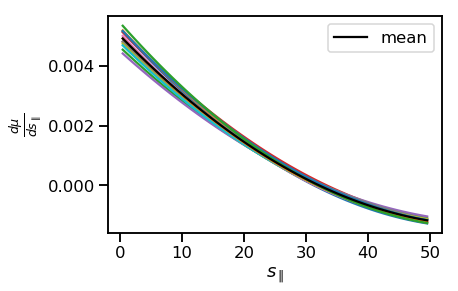

In [291]:
derivative_ind = []
sperp = 48
for i in range(len(central_halos)):
    m1 = simps(central_halos[i].jointpdf[sperp,:] * vlos**2, vlos, axis  = -1)
    m1_interp = UnivariateSpline(central_halos[0].r.r, 
                m1, s=0.3, k=4)#fill_value = (m1[0], m1[-1]),bounds_error = False)

    #plt.plot(central_halos[0].r.r,m1_interp(central_halos[0].r.r))
    #plt.plot(central_halos[0].r.r, m1, linestyle = '', markersize = 2, marker='o')
    
    #plt.show()

    values = m1_interp.derivative(n=2)(central_halos[0].r.t)

    plt.plot(central_halos[0].r.t, values)
    derivative_ind.append(values)

derivative_mean = np.mean(derivative_ind, axis=0)
    
plt.plot(central_halos[0].r.t,derivative_mean, color='black', label='mean')
plt.legend()
plt.xlabel(r'$s_\parallel$')
plt.ylabel(r'$\frac{d \mu}{d s_\parallel}$')

Text(0, 0.5, '$\\frac{d ^2\\sigma}{d s_\\parallel^2}$')

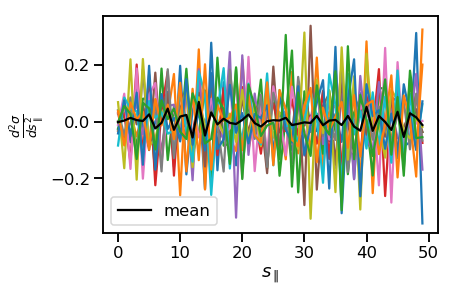

In [240]:
derivative_ind = []
for i in range(len(central_halos)):
    m1 = simps(central_halos[i].jointpdf[sperp,:] * vlos**2, vlos, axis  = -1)
    m1_interp = interp1d(central_halos[0].r.r, m1, fill_value = (m1[0], m1[-1]),bounds_error = False)


    plt.plot(derivative(m1_interp, central_halos[0].r.t, n=2, order=5))
    derivative_ind.append(derivative(m1_interp, central_halos[0].r.t, n=2,order=5))
    
derivative_mean = np.mean(derivative_ind, axis=0)
    
plt.plot(derivative_mean, color='black', label='mean')
plt.legend()
plt.xlabel(r'$s_\parallel$')
plt.ylabel(r'$\frac{d ^2\sigma}{d s_\parallel^2}$')

In [ ]:
interp_twopcf = UnivariateSpline(mean_tpcf_dict['r'], mean_tpcf_dict['tpcf'], k = 3, s=0)

plt.loglog(mean_tpcf_dict['r'], mean_tpcf_dict['tpcf'], linestyle='', marker='o', markersize=3)
plt.loglog(mean_tpcf_dict['r'], interp_twopcf(mean_tpcf_dict['r']))

In [22]:
interp_twopcf = UnivariateSpline(mean_tpcf_dict['r'], mean_tpcf_dict['tpcf'], k = 3, s=0.)

approx = np.zeros((len(central_halos[0].r.t), len(central_halos[0].r.t)))
for i, rperp in enumerate(central_halos[0].r.t):
    
        
    m1 = simps(mean_los_pdf[i,:] * vlos, vlos, axis  = -1)

    m1_interp = UnivariateSpline(central_halos[0].r.r, 
            m1, s=0.1, k=5)

    m2 = simps(mean_los_pdf[i,:] * (vlos )**2, vlos, axis  = -1)
    
    m2_interp = UnivariateSpline(central_halos[0].r.r, 
            m2, s=0.1, k=5)


    for j, rpar in enumerate(central_halos[0].r.t):
        
        dm1_s = m1_interp.derivative(n=1)(rpar)
      
        dm2_s = m2_interp.derivative(n=1)(rpar)
        
        ddm2_s = m2_interp.derivative(n=2)(rpar)


        r = np.sqrt(rperp ** 2 + rpar**2)

        
        approx[i,j] = interp_twopcf(r) - dm1_s +  0.5 *  ddm2_s

        

In [109]:
approx_no_smooth = np.zeros((len(central_halos[0].r.t), len(central_halos[0].r.t)))
for i, rperp in enumerate(central_halos[0].r.t):
    
    m1 = simps(mean_los_pdf[i,:] * vlos, vlos, axis  = -1)

    m1_interp = UnivariateSpline(central_halos[0].r.r, 
            m1, s=0.01, k=3, ext=1)

    m2 = simps(mean_los_pdf[i,:] * (vlos )**2, vlos, axis  = -1)
    
    m2_interp = UnivariateSpline(central_halos[0].r.r, 
            m2, s=0.011, k=3, ext=1)


    for j, rpar in enumerate(central_halos[0].r.t):
        
        dm1_s = m1_interp.derivative(n=1)(rpar)
      
        dm2_s = m2_interp.derivative(n=1)(rpar)
        
        ddm2_s = m2_interp.derivative(n=2)(rpar)


        r = np.sqrt(rperp ** 2 + rpar**2)
        
        approx_no_smooth[i,j] = interp_twopcf(r) - dm1_s +  0.5 *  ddm2_s

In [110]:
approx_tpcf = np.zeros((len(central_halos[0].r.t), len(central_halos[0].r.t)))
for i, rperp in enumerate(central_halos[0].r.t):
    
        
    m1 = simps(mean_los_pdf[i,:] * vlos, vlos, axis  = -1)

    m1_interp = UnivariateSpline(central_halos[0].r.r, 
            m1, s=0.1, k=5)

    m2 = simps(mean_los_pdf[i,:] * (vlos )**2, vlos, axis  = -1)
    
    m2_interp = UnivariateSpline(central_halos[0].r.r, 
            m2, s=0.1, k=5)


    for j, rpar in enumerate(central_halos[0].r.t):
        
        dm1_s = m1_interp.derivative(n=1)(rpar)
      
        dm2_s = m2_interp.derivative(n=1)(rpar)
        
        ddm2_s = m2_interp.derivative(n=2)(rpar)


        r = np.sqrt(rperp ** 2 + rpar**2)
        
        jacobian1 = rpar/r
        jacobian2 = rperp**2/(rperp**2 + rpar**2)**(3./2.)
        
        approx_tpcf[i,j] = ( 1  +  interp_twopcf(r) ) * (1 - dm1_s +  0.5 *  ddm2_s) \
                        - interp_twopcf.derivative(n=1)(r)*jacobian1*m1_interp(rpar) \
                        + interp_twopcf.derivative(n=1)(r)*jacobian1* dm2_s \
                        + 0.5 *interp_twopcf.derivative(n=2)(r)*jacobian2*m2_interp(rpar)  \
                        - 1.
        

In [111]:
levels = np.arange(-4, 1, 0.3)


In [112]:
#approx[:-1,:5] = measured_pi_sigma[:, :5]
#approx_tpcf[:-1,:5] = measured_pi_sigma[:, :5]

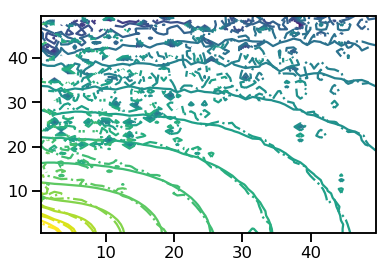

In [113]:
plt.contour(list_dictionaries[0]['r'], list_dictionaries[0]['r'] ,np.log10(measured_pi_sigma).T,
            levels = levels)

#plt.contour(central_halos[0].r.t, central_halos[0].r.t ,np.log10(approx).T,
#            levels = levels, linestyles='dotted')

#plt.contour(central_halos[0].r.t, central_halos[0].r.t ,np.log10(approx_tpcf).T,
#            levels = levels, linestyles='dashed')


plt.contour(central_halos[0].r.t, central_halos[0].r.t ,np.log10(approx_no_smooth).T,
            levels = levels, linestyles='-.')

In [114]:
mu_c = 0.5 * (mu[1:] + mu[:-1])

In [115]:
pi_sigma_interpolation =interp2d(central_halos[0].r.t,
            central_halos[0].r.t, approx, kind='linear')

pi_sigma_interpolation_tpcf =interp2d(central_halos[0].r.t,
            central_halos[0].r.t, approx_tpcf, kind='linear')

pi_sigma_interpolation_no_smooth =interp2d(central_halos[0].r.t,
            central_halos[0].r.t, approx_no_smooth, kind='linear')

s_mu_approx = np.zeros_like(s_mu)

s_mu_approx_tpcf = np.zeros_like(s_mu)
s_mu_approx_no_smooth = np.zeros_like(s_mu)

for i, s_value in enumerate(s_c):
    for j, mu_value in enumerate(mu_c):
        r_parallel = mu_value * s_value
        r_perpendicular = np.sqrt(s_value**2 - r_parallel**2)
        
        s_mu_approx[i,j] = pi_sigma_interpolation(r_parallel,
                                r_perpendicular)
        
        s_mu_approx_tpcf[i,j] = pi_sigma_interpolation_tpcf(r_parallel,
                                r_perpendicular)
        
        
        s_mu_approx_no_smooth[i,j] = pi_sigma_interpolation_no_smooth(r_parallel,
                                r_perpendicular)
        


In [116]:
        
monopole_approx = tpcf_multipole(s_mu_approx, mu, order = 0)
quadrupole_approx = tpcf_multipole(s_mu_approx, mu, order = 2)
hexadecapole_approx = tpcf_multipole(s_mu_approx, mu, order = 4)

monopole_approx_tpcf = tpcf_multipole(s_mu_approx_tpcf, mu, order = 0)
quadrupole_approx_tpcf = tpcf_multipole(s_mu_approx_tpcf, mu, order = 2)
hexadecapole_approx_tpcf = tpcf_multipole(s_mu_approx_tpcf, mu, order = 4)

monopole_approx_no_smooth = tpcf_multipole(s_mu_approx_no_smooth, mu, order = 0)
quadrupole_approx_no_smooth = tpcf_multipole(s_mu_approx_no_smooth, mu, order = 2)
hexadecapole_approx_no_smooth = tpcf_multipole(s_mu_approx_no_smooth, mu, order = 4)

## Compare multipoles

In [33]:
s_mu = real2red.integrate(rparallel, integrand)
monopole = tpcf_multipole(s_mu, mu, order = 0)
quadrupole = tpcf_multipole(s_mu, mu, order = 2)
hexadecapole = tpcf_multipole(s_mu, mu, order = 4)

In [34]:
bf_st_s_mu = real2red.integrate(rparallel, bf_st_integrand)
bf_st_monopole = tpcf_multipole(bf_st_s_mu, mu, order = 0)
bf_st_quadrupole = tpcf_multipole(bf_st_s_mu, mu, order = 2)
bf_st_hexadecapole = tpcf_multipole(bf_st_s_mu, mu, order = 4)

In [35]:
st_s_mu = real2red.integrate(rparallel, st_integrand)
st_monopole = tpcf_multipole(st_s_mu, mu, order = 0)
st_quadrupole = tpcf_multipole(st_s_mu, mu, order = 2)
st_hexadecapole = tpcf_multipole(st_s_mu, mu, order = 4)

In [36]:
bf_gaussian_s_mu = real2red.integrate(rparallel, bf_gaussian_integrand)
bf_gaussian_monopole = tpcf_multipole(bf_gaussian_s_mu, mu, order = 0)
bf_gaussian_quadrupole = tpcf_multipole(bf_gaussian_s_mu, mu, order = 2)
bf_gaussian_hexadecapole = tpcf_multipole(bf_gaussian_s_mu, mu, order = 4)

In [37]:
gaussian_s_mu = real2red.integrate(rparallel, gaussian_integrand)
gaussian_monopole = tpcf_multipole(gaussian_s_mu, mu, order = 0)
gaussian_quadrupole = tpcf_multipole(gaussian_s_mu, mu, order = 2)
gaussian_hexadecapole = tpcf_multipole(gaussian_s_mu, mu, order = 4)

In [38]:
s_c = 0.5 * (s[1:] + s[:-1])

Text(0.5, 0, '$s$ [Mpc/h]')

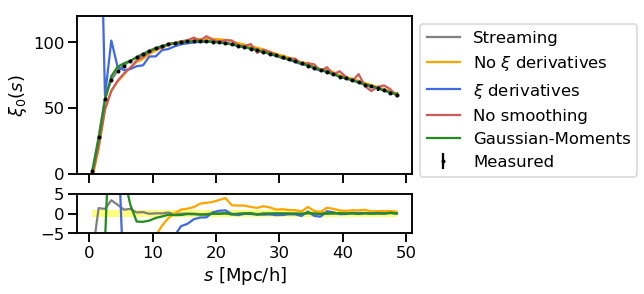

In [117]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(s_c, s_c*s_c*mean_mono,
            yerr = s_c * s_c * std_mono, 
             color = 'black', linestyle='', label = 'Measured', marker='o', markersize=3)

ax1.plot(s_c, s_c*s_c*monopole, color='gray', label='Streaming')
ax1.plot(s_c, s_c*s_c*monopole_approx, color='orange', label=r'No $\xi$ derivatives ')
ax1.plot(s_c, s_c*s_c*monopole_approx_tpcf, color='royalblue', label=r'$\xi$ derivatives ')
ax1.plot(s_c, s_c*s_c*monopole_approx_no_smooth, color='indianred', label=r'No smoothing ')

ax1.plot(s_c, s_c*s_c*gaussian_monopole, color='forestgreen', label='Gaussian-Moments')


ax1.legend(bbox_to_anchor = (1,1))
ax1.set_ylabel(r'$\xi_0(s)$')

ax2.plot(s_c, (monopole - mean_mono)/std_mono,
        color = 'gray')

ax2.plot(s_c, (monopole_approx - mean_mono)/std_mono,
        color = 'orange')
ax2.plot(s_c, (monopole_approx_tpcf - mean_mono)/std_mono,
        color = 'royalblue')
ax2.plot(s_c, (gaussian_monopole - mean_mono)/std_mono,
        color = 'forestgreen')

ax2.fill_between(s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5)
ax1.set_ylim(0,120)

ax2.set_xlabel(r'$s$ [Mpc/h]')

Text(0.5, 0, '$s$ [Mpc/h]')

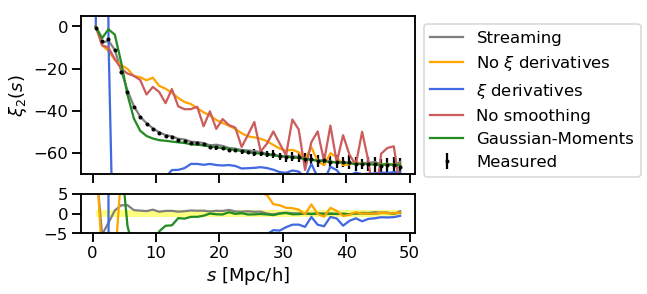

In [118]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(s_c, s_c*s_c*mean_quad,
            yerr = s_c * s_c * std_quad, 
             color = 'black', linestyle='', label = 'Measured', marker='o', markersize=3)

ax1.plot(s_c, s_c*s_c*quadrupole, color='gray', label='Streaming')
ax1.plot(s_c, s_c*s_c*quadrupole_approx, color='orange', label=r'No $\xi$ derivatives ')
ax1.plot(s_c, s_c*s_c*quadrupole_approx_tpcf, color='royalblue', label=r'$\xi$ derivatives ')
ax1.plot(s_c, s_c*s_c*quadrupole_approx_no_smooth, color='indianred', label=r'No smoothing ')



ax1.plot(s_c, s_c*s_c*gaussian_quadrupole, color='forestgreen', label='Gaussian-Moments')


ax1.legend(bbox_to_anchor = (1,1))
ax1.set_ylabel(r'$\xi_2(s)$')

ax2.plot(s_c, (quadrupole - mean_quad)/std_quad,
        color = 'gray')
ax2.plot(s_c, (gaussian_quadrupole - mean_quad)/std_quad,
        color = 'forestgreen')

ax2.plot(s_c, (quadrupole_approx - mean_quad)/std_quad,
         color = 'orange')
ax2.plot(s_c, (quadrupole_approx_tpcf - mean_quad)/std_quad,
         color = 'royalblue')

ax2.fill_between(s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5.,5)
ax1.set_ylim(-70,5)


ax2.set_xlabel(r'$s$ [Mpc/h]')

Text(0.5, 0, '$s$ [Mpc/h]')

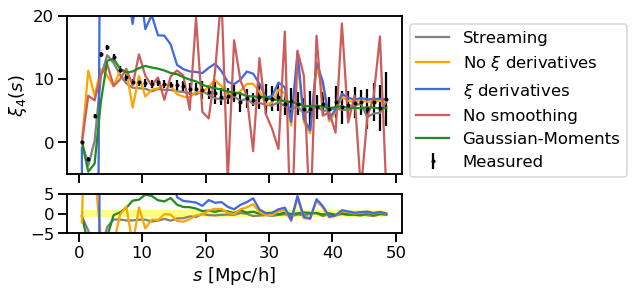

In [119]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.errorbar(s_c, s_c*s_c*mean_hexa,
            yerr = s_c * s_c * std_hexa, 
             color = 'black', linestyle='', label = 'Measured', marker='o', markersize=3)

ax1.plot(s_c, s_c*s_c*hexadecapole, color='gray', label='Streaming')
ax1.plot(s_c, s_c*s_c*hexadecapole_approx, color='orange', label = r'No $\xi$ derivatives ')
ax1.plot(s_c, s_c*s_c*hexadecapole_approx_tpcf, color='royalblue', label = r'$\xi$ derivatives ')
ax1.plot(s_c, s_c*s_c*hexadecapole_approx_no_smooth, color='indianred', label=r'No smoothing ')

ax1.plot(s_c, s_c*s_c*gaussian_hexadecapole, color='forestgreen', label='Gaussian-Moments')


ax1.legend(bbox_to_anchor = (1,1))
ax1.set_ylabel(r'$\xi_4(s)$')

ax2.plot(s_c, (hexadecapole - mean_hexa)/std_hexa,
        color = 'gray')

ax2.plot(s_c, (gaussian_hexadecapole - mean_hexa)/std_hexa,
        color = 'forestgreen')
ax2.plot(s_c, (hexadecapole_approx - mean_hexa)/std_hexa,
        color = 'orange')
ax2.plot(s_c, (hexadecapole_approx_tpcf - mean_hexa)/std_hexa,
        color = 'royalblue')

ax2.fill_between(s_c,-1., 1., facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(-5,5)
ax1.set_ylim(-5,20)



ax2.set_xlabel(r'$s$ [Mpc/h]')